# Devanagari Image Querying Using A Convolutional Neural Network Autoencoder and k-Nearest Neighbors
Devanagiri is the alphabet writing system used for Sanskrit, Hindi, and other Indian languages. Our dataset is set up as a row of pixels per image in a csv file. 

Given an Devanagari image, we want to query the database and return five images that are closest to the query image. For this, we will design and train a convolutional neural net autoencoder on the images. 

A properly trained autoencoder allows the images to have a simpler representation in latent space. This condense encoding is easier to search and is then used by a k-nearest neighbor algorithm to find other images whose encodings are most similar, translating to similar images.  

Let's analyze the data further to have a better idea of our dataset.

In [1]:
import pandas as pd

file = 'devanagiri.csv'
data = pd.read_csv(file)
print("Data shape: ", data.shape)
print(data.head(5))

Data shape:  (7702, 3073)
  label  x_0  x_1  x_2  x_3  x_4  x_5  x_6  x_7  x_8  ...  x_3062  x_3063  \
0     i  211  243  254  211  243  254  210  242  253  ...     242     211   
1    ti  201  229  236  205  232  239  202  230  235  ...     246     206   
2     a  214  243  252  214  243  252  213  242  251  ...     233     193   
3  smaa  212  241  250  212  241  250  212  241  250  ...     249     213   
4   kaM  215  243  250  215  243  250  214  242  249  ...     241     201   

   x_3064  x_3065  x_3066  x_3067  x_3068  x_3069  x_3070  x_3071  
0     240     245     213     242     247     213     242     247  
1     234     245     204     233     242     204     233     242  
2     222     231     192     221     230     192     221     230  
3     241     252     212     240     251     210     238     249  
4     231     241     201     231     242     202     232     243  

[5 rows x 3073 columns]


Given to us beforehand, the images are 32 x 32 x 3, which is 3072 pixels. The data has 7702 rows and each row is an image with 3072 pixels with the first column as the label for the image.

#### Exploratory Data Analysis
We will clean up the data by checking the data for duplicates and for null values.

In [2]:
# Check for possible duplicates
data = data.drop_duplicates()
print("After dropping duplicates: ", data.shape)

# Check for null values
print(f'This many null values total: {data.isnull().sum().sum()}')

After dropping duplicates:  (7702, 3073)
This many null values total: 49


There seem to be no duplicates however we have 49 rows with null values.

Let's examine these rows.

In [3]:
# Find which rows have null values
nan_rows = data[data.isnull().any(1)]

print(nan_rows)

     label  x_0  x_1  x_2  x_3  x_4  x_5  x_6  x_7  x_8  ...  x_3062  x_3063  \
51     NaN  210  237  247  205  232  242  198  225  235  ...     247     209   
4741   NaN  215  240  247  216  240  246  216  239  245  ...     241     207   
4934   NaN  203  230  242  203  231  242  203  231  242  ...     246     204   
4935   NaN  218  247  254  217  246  253  216  244  252  ...     245     201   
5119   NaN  156  188  204  155  188  204  154  188  204  ...     204     150   
5333   NaN  158  186  210  158  186  210  158  186  210  ...     213     162   
5355   NaN  158  182  201  157  181  200  156  181  200  ...     199     156   
5358   NaN  155  182  199  155  182  199  156  182  200  ...     203     161   
5386   NaN  163  191  211  163  191  211  164  191  210  ...     205     153   
5448   NaN   65   73   90   65   71   94   63   68   95  ...     213     162   
5449   NaN  144  168  190  145  170  192  148  172  196  ...     215     162   
5450   NaN  149  171  199  148  170  199

These rows have null labels but since the image pixels seem to be intact, we do not need to remove them since we will not be using labels in our methodology.

To recap our method, we will:
1) design and train an autoencoder 
2) then use k-nearest neighbors to query the image. 

The autoencoder does not need a label set since it will be trained on the image it was fed with. Our k-nearest neighbor algorithm is an unsupervised learning method and will also not need a labeled set.

Now we will separate the label column from the dataframe.

In [4]:
# Separate label column
labels = data.pop('label')

For further exploratory data analysis, let's analyze the labels. Devanagari has 47 primary characters according to Wikipedia.

In [5]:
# Number of unique labels
print(labels.nunique())

601


There are 601 unique labels! Almost 12 times our expected number of 47 characters for the writing system. There must be differences in spelling, mislabels, and/or possibly irrevelant images.

Fortunately, this will have no consequences for our methods since we will not be using the labels at all.

#### Data Processing
Now we can begin reconstructing the images from the row of pixels.

In [6]:
import numpy as np
import cv2

# Reconstructing the images from the row of pixels
data_rows = data.shape[0]
images = []
for i in range(1,data_rows): # Start at 1 to skip the header
    img = np.array(data.iloc[i], dtype = np.float32)
    img = img / 255
    img = img.reshape(32,32,3)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    images.append(img)
    
# Checking the shape of our image array
images = np.array(images)
print(f'Images shape: {len(images)}')

Images shape: 7701


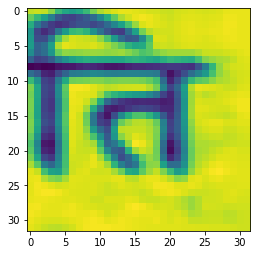

In [7]:
# Checking our image
import matplotlib.pyplot as plt

plt.figure('image',figsize = (4,6))
plt.imshow(images[0])

#### Building and training the model
First we set aside a held-out set for testing. Then build and train the model.

We will be building an autoencoder with a convolutional neural network. The network will extract features from the image, condense it into latent space, and decompress it back to its original image as close as possible.

In [10]:
# Set aside an untouched test set 
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(images, test_size=0.2)

print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (6160, 32, 32)
Test data shape: (1541, 32, 32)


In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D

BATCH = 32
EPOCHS = 1 # For testing

# Build the model
def build_model():
    input_layer = Input(shape=(32,32,1)) # The 32x32 size of the original input is pretty small so we will keep filters at 8
    x = BatchNormalization()(input_layer)
    x = Conv2D(8,(3,3),activation='relu',padding='same')(x) # Padding is the same throughout so output size matches image sizes for training the autoencoder (squeeze it then expand it to see if it encodes well)
    #x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(16,(3,3),activation='relu',padding='same')(x)
    #x = BatchNormalization()(x)
    encoded = MaxPooling2D(2, name='encoder')(x) # This is the encoded representation

    x = Conv2DTranspose(8,(3,3),activation='relu',padding='same')(encoded)
    x = UpSampling2D(2)(x)
    x = Conv2DTranspose(1,(3,3),activation='sigmoid',padding='same')(x)
    out = UpSampling2D(2)(x)

    model = Model(input_layer, out)
    print(model.summary())
    
    # Compile the model
    model.compile(
        loss = 'mse', # mse to minimize the pixel value differences
        optimizer = 'adam'
        )

    return model

autoencoder = build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 encoder (MaxPooling2D)      (None, 8, 8, 16)          0     

Now train the autoencoder model using the same input image as the label set.

In [15]:
# Train model
history = autoencoder.fit(
    train_data,
    train_data, # Trained on input image
    batch_size = BATCH,
    epochs = EPOCHS
    )

193/193 [==============================] - 3s 12ms/step - loss: 0.0185


#### Evaluate the model
Let's see how the model did.

In [16]:
# Final evaluation on held out set
scores = autoencoder.evaluate(
    test_data,
    test_data,
    )

print(f'These are test data scores: {scores}')

49/49 [==============================] - 0s 5ms/step - loss: 0.0187
These are test data scores: 0.018693121150135994


The loss doesn't tell us much about the decompressed image. We will run the model on our earlier image to see how it looks.

(1, 32, 32, 1)
(32, 32)


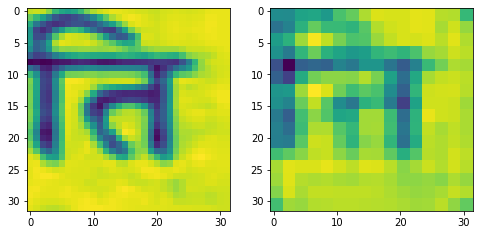

In [32]:
sample_img = images[0]
sample_img = np.expand_dims(sample_img, axis=0) # To meet model input dimension requirement

predict_img = autoencoder.predict(sample_img)
predict_img = np.squeeze(predict_img) # To display with image dimensions

plt.figure('predicted image',figsize = (8,6))
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.subplot(1, 2, 2)
plt.imshow(predict_img)

The reconstructed image is rough but we can enough traces of the original image to spot similarities. Our encoded representation could be improved but is at least sufficient enough for use.

#### Building the kNN model for Querying
Now we pull out the encoded representation from the autoencoder model to train and build the k-nearest neighbor model.

We will also use the whole dataset, including the test set, to train the model so we can look for similar images within the whole set. 

However, we will pull our random query image from the test set to simulate how well our models work on out-of-sample data. We will also have to delete the query image from our new dataset as it is trivial to return the same image we queried with.

In [34]:
import random

# Create encoder for KNN querying
encoder = Model(inputs = autoencoder.inputs, outputs = autoencoder.get_layer('encoder').output)

# Query image from held out set where model never saw the query
random_idx = random.randint(1, test_data.shape[0])
query = test_data[random_idx]

# Delete query image from the entire set
print(f'Test data shape: {test_data.shape}')
new_testd = np.delete(test_data, random_idx, axis = 0)
print(f'New Test data shape: {new_testd.shape}')
whole_data = np.concatenate([train_data, new_testd])
print(f'New Complete data shape: {whole_data.shape}')

Test data shape: (1541, 32, 32)
New Test data shape: (1540, 32, 32)
New Complete data shape: (7700, 32, 32)


In order to train the kNN model, we have to encode the whole training set, then flattened down to two dimensions in order to train the kNN, before finally fitting the kNN on those representations.

In [36]:
# Get the latent space representation of the dataset
data_encoded = encoder.predict(whole_data)
query_encoded = encoder.predict(query.reshape(1,32,32,1)) # Have to reshape as explicitly one item since one entry is not interpreted correctly

In [37]:
from sklearn.neighbors import NearestNeighbors

# Using kNN to perform the query
neighbors = 5
kNN = NearestNeighbors(n_neighbors = neighbors)

# Train the kNN model on encoded dataset (with the query image deleted)
kNN.fit(data_encoded.reshape(-1,8*8*16)) # Reshape since kNN takes only 2 dim items

NearestNeighbors()

Repeating the reshape for the query image to two dimensions to use the kNN, we then reshape the results back to display the images.

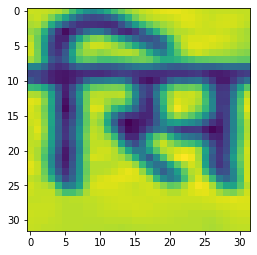

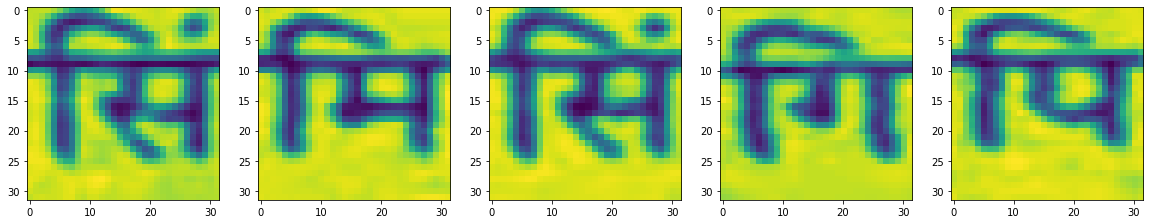

In [38]:
# Now find the nearest neighbors
distances, indices = kNN.kneighbors(query_encoded.reshape(1,8*8*16))

# Use the indices to display the images most similar to the query image
query_results = whole_data[indices]
query_results = query_results.reshape(-1,32,32,1)

# Display the closest images
plt.figure('original image',figsize = (4,6))
plt.imshow(query.reshape(32,32,1))

plt.figure('closest images',figsize = (20,6))
for i in range(neighbors):
    ax = plt.subplot(1, neighbors, i+1)
    plt.imshow(query_results[i].reshape(32,32,1))

plt.show()

#### Conclusion
Success! The five closest images are very similar to our query. This conclusion our Devanagari CNN autoencoder with kNN for querying images.